<a href="https://colab.research.google.com/github/DilemmaFixer3/AI_labs/blob/main/Lab4_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import zipfile

# -----------------------
# РОЗПАКУВАННЯ АРХІВУ
# -----------------------
zip_path = 'archive.zip'
extract_path = './brain_tumor_dataset'

if not os.path.exists(extract_path):
    os.makedirs(extract_path)

print(f"Розпакування {zip_path} до {extract_path}...")
try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Розпакування завершено.")
except FileNotFoundError:
    print(f"Помилка: Файл {zip_path} не знайдено. Переконайтеся, що ви завантажили архів у середовище Colab.")

# -----------------------
# Встановлення шляхів до даних
# -----------------------
train_dir = os.path.join(extract_path, 'Training')
test_dir = os.path.join(extract_path, 'Testing')

# Перевірка наявності папок перед продовженням
if not os.path.exists(train_dir) or not os.path.exists(test_dir):
    print("Помилка: Папки 'Training' або 'Testing' не знайдено після розпакування.")
    # Припиняємо виконання, якщо дані відсутні
    # raise SystemExit("Неможливо продовжити без тренувальних та тестових даних.")
    classes = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
else:
    classes = sorted(os.listdir(train_dir))

num_classes = len(classes)
print(f"Класифікаційне завдання: {num_classes} класів.")
print(f"Імена класів: {classes}")

Розпакування archive.zip до ./brain_tumor_dataset...
Розпакування завершено.
Класифікаційне завдання: 4 класів.
Імена класів: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [5]:
# -----------------------
# ОПТИМІЗОВАНІ ПАРАМЕТРИ
# -----------------------
IMG_SIZE = 150 # Зменшення розміру зображень (БУЛО 224, стало 150)
BATCH_SIZE = 32
EPOCHS = 20 # Зменшення максимальної кількості епох

# Генератор для тренувальної вибірки (з аугментацією та нормалізацією)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15, # Зменшено з 20
    width_shift_range=0.08, # Зменшено з 0.1
    height_shift_range=0.08, # Зменшено з 0.1
    shear_range=0.08,
    zoom_range=0.08,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Генератор для валідаційної вибірки
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Генератор для тестової вибірки
test_datagen = ImageDataGenerator(rescale=1./255)


# Створення генераторів даних

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    seed=42
)

validation_generator = validation_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"Тренувальна вибірка: {train_generator.samples} зображень, розмір: {IMG_SIZE}x{IMG_SIZE}.")
print(f"Валідаційна вибірка: {validation_generator.samples} зображень, розмір: {IMG_SIZE}x{IMG_SIZE}.")
print(f"Тестова вибірка: {test_generator.samples} зображень, розмір: {IMG_SIZE}x{IMG_SIZE}.")

Found 2297 images belonging to 4 classes.
Found 573 images belonging to 4 classes.
Found 394 images belonging to 4 classes.
Тренувальна вибірка: 2297 зображень, розмір: 150x150.
Валідаційна вибірка: 573 зображень, розмір: 150x150.
Тестова вибірка: 394 зображень, розмір: 150x150.


In [6]:
# Рекомендовані налаштування:
LEARNING_RATE = 0.001
DROPOUT_RATE = 0.4
LOSS_FUNCTION = 'categorical_crossentropy'
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

# Завантаження ResNet50 з НОВИМ розміром входу
base_model = ResNet50(weights='imagenet',
                      include_top=False,
                      input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Заморожування шарів базової моделі
base_model.trainable = False

# Створення моделі
model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(DROPOUT_RATE),
    Dense(num_classes, activation='softmax')
])

# Компіляція моделі
model.compile(optimizer=OPTIMIZER,
              loss=LOSS_FUNCTION,
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])

model.summary()

# Callbacks
# Early Stopping: зупинка, якщо val_loss не покращується протягом 4 епох (було 5)
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_optimized.keras', monitor='val_loss', save_best_only=True)

# Навчання моделі
print("\nПочаток навчання моделі...")
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[early_stopping, model_checkpoint]
)
print("Навчання завершено.")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 5, 5, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    26,214,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,804,676 (189.99 MB)

 Trainable params: 26,216,964 (100.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)


Початок навчання моделі...
Epoch 1/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 281s 4s/step - accuracy: 0.3024 - loss: 3.9370 - precision: 0.2985 - recall: 0.2071 - val_accuracy: 0.4357 - val_loss: 1.2418 - val_precision: 0.8529 - val_recall: 0.0533
Epoch 2/20
 1/71 ━━━━━━━━━━━━━━━━━━━━ 3:04 3s/step - accuracy: 0.4375 - loss: 1.2323 - precision: 0.6000 - recall: 0.0938

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


71/71 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.4375 - loss: 1.2323 - precision: 0.6000 - recall: 0.0938 - val_accuracy: 0.4228 - val_loss: 1.2421 - val_precision: 0.8824 - val_recall: 0.0551
Epoch 3/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 330s 5s/step - accuracy: 0.4397 - loss: 1.1966 - precision: 0.5750 - recall: 0.1008 - val_accuracy: 0.4375 - val_loss: 1.2336 - val_precision: 0.7807 - val_recall: 0.1636
Epoch 4/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 53s 726ms/step - accuracy: 0.6250 - loss: 1.0423 - precision: 0.7143 - recall: 0.1562 - val_accuracy: 0.4688 - val_loss: 1.2164 - val_precision: 0.8370 - val_recall: 0.1415
Epoch 5/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 262s 4s/step - accuracy: 0.4925 - loss: 1.1361 - precision: 0.5848 - recall: 0.1828 - val_accuracy: 0.4559 - val_loss: 1.2642 - val_precision: 0.6162 - val_recall: 0.2096
Epoch 6/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.5000 - loss: 1.2303 - precision: 0.6667 - recall: 0.2500 - val_accuracy: 0.4614 - val_loss: 1.2578 - val_preci


Оцінка моделі на тестовій вибірці...
12/12 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.2298 - loss: 3.2444 - precision: 0.1965 - recall: 0.0980

---------------------------------
ФІНАЛЬНИЙ ЗВІТ ПРО ЯКІСТЬ МОДЕЛІ
---------------------------------
Test Loss: 2.1969
Test Accuracy (Точність): 0.2995
Test Precision (Прецизійність): 0.3690
Test Recall (Повнота): 0.1797
13/13 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step

Повний звіт класифікації (Precision, Recall, F1-Score):
                  precision    recall  f1-score   support

    glioma_tumor       0.29      0.21      0.24       100
meningioma_tumor       0.33      0.22      0.26       115
        no_tumor       0.28      0.43      0.34       105
 pituitary_tumor       0.38      0.45      0.41        74

        accuracy                           0.31       394
       macro avg       0.32      0.33      0.31       394
    weighted avg       0.32      0.31      0.31       394



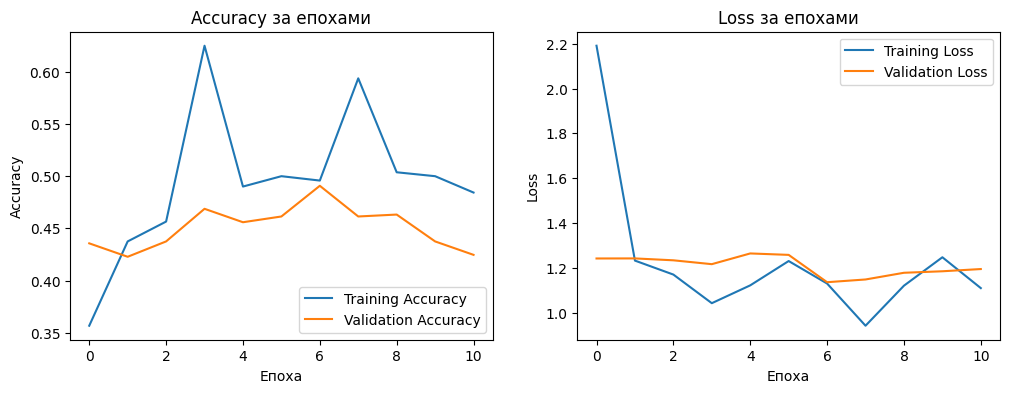

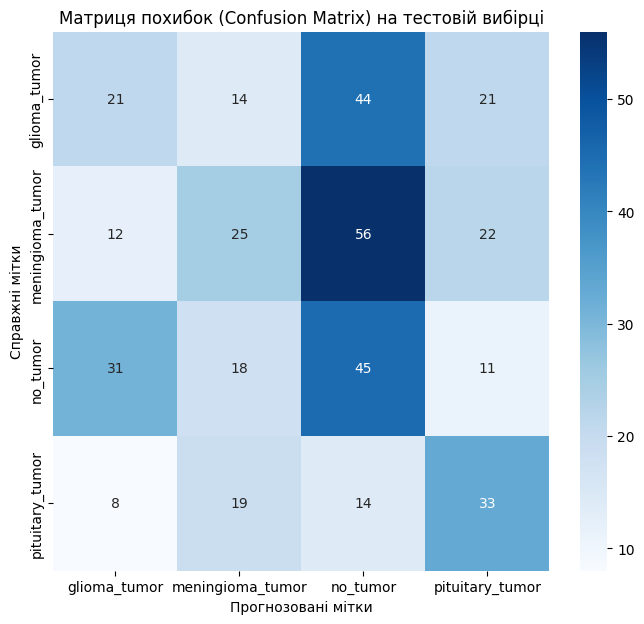

In [7]:
# -----------------------
# 4. ОЦІНКА ЯКОСТІ НА ТЕСТОВІЙ ВИБІРЦІ
# -----------------------

print("\nОцінка моделі на тестовій вибірці...")
# Використовуємо .evaluate()
loss, acc, prec, rec = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE, verbose=1)

print("\n---------------------------------")
print("ФІНАЛЬНИЙ ЗВІТ ПРО ЯКІСТЬ МОДЕЛІ")
print("---------------------------------")
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy (Точність): {acc:.4f}")
print(f"Test Precision (Прецизійність): {prec:.4f}")
print(f"Test Recall (Повнота): {rec:.4f}")

# Отримання детальних метрик (F1-score, Confusion Matrix)
Y_pred = model.predict(test_generator, steps=test_generator.samples // BATCH_SIZE + 1)
y_pred_classes = np.argmax(Y_pred, axis=1)

# Справжні мітки
y_true = test_generator.classes
y_true = y_true[:len(y_pred_classes)]

# Матриця похибок
cm = confusion_matrix(y_true, y_pred_classes)

# Детальний звіт
report = classification_report(y_true, y_pred_classes, target_names=classes, zero_division=0)
print("\nПовний звіт класифікації (Precision, Recall, F1-Score):")
print(report)


# -----------------------
# 5. ВІЗУАЛІЗАЦІЯ
# -----------------------

# Візуалізація 1: Графіки навчання
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy за епохами')
plt.xlabel('Епоха')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss за епохами')
plt.xlabel('Епоха')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Візуалізація 2: Confusion Matrix
plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Матриця похибок (Confusion Matrix) на тестовій вибірці')
plt.ylabel('Справжні мітки')
plt.xlabel('Прогнозовані мітки')
plt.show()